# Project 1: Calibration

In [1]:
# used to reload the imported modules on save
%load_ext autoreload
%autoreload 2

import utils as u

In [2]:
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import yaml
import cv2
import os

In [3]:
# constants
grid_size = (8,11)
square_size = 11

# getting the images path
images_pathname = "../images_and_poses_for_project_assignment/"
images_path = [os.path.join(images_pathname, imagename) for imagename in os.listdir(images_pathname) if imagename.endswith(".png")]
poses_path = [os.path.join(images_pathname, pose) for pose in os.listdir(images_pathname) if pose.endswith(".yaml")]

# Sorting the lists of strings in numerical order
images_path.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))
poses_path.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))

## Exercise 1

Calibrate using the Zhang procedure [Zhang, 2002], i.e., find the intrinsic parameters $K$ and, for each image, the pair of $R, t$ (extrinsic)

In [4]:
V = []
all_H = []  # saving the homographies for each image

# getting the homographies
for img in images_path:
    _, H = u.get_homography(img, grid_size, square_size)
    all_H.append(H)
    
    v_12 = u.get_v_vector(H, 1, 2)
    v_11 = u.get_v_vector(H, 1, 1)
    v_22 = u.get_v_vector(H, 2, 2)
    
    V.append(v_12)
    V.append(v_11 - v_22)
    
# computing params
V = np.array(V)
K = u.get_intrinsic(V)

# computing extrinsic for one image
all_R = []
all_t = []

for H in all_H:
    R, t = u.get_extrinsic(K, H)
    all_R.append(R)
    all_t.append(t)

# TODO: make a better log
print("Example params: \n")
print(f"- K -\n{K}\n")
print(f"- R -\n{all_R[0]}\n")
print(f"- t - \n{all_t[0]}\n")


Example params: 

- K -
[[1.01843855e+03 4.23645592e+00 6.40932181e+02]
 [0.00000000e+00 1.01903693e+03 3.68015507e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

- R -
[[ 0.99923991  0.03841311  0.00663541]
 [ 0.03857036 -0.99893134 -0.02546593]
 [ 0.00565009  0.0257025  -0.99965367]]

- t - 
[-59.68991101  44.05057245 288.25946948]



## Exercise 2

Choose one of the calibration images and compute the total reprojection error (`Lecture 3, page 45`) for all the grid points (adding a figure with the reprojected points).

In [5]:
# getting the image and extrinsics
img_path = images_path[1]
R1 = all_R[1]
t1 = all_t[1]

# combining R and t
P = u.get_projection_matrix(K, R1, t1)

corners = u.get_corners(img_path, grid_size)
projected_corners = []

error = 0
for index, corner in enumerate(corners):
    u_coord = corner[0]
    v_coord = corner[1]

    grid_size_cv2 = tuple(reversed(grid_size))
    u_index, v_index = np.unravel_index(index, grid_size_cv2)

    # the coordinates of the corner w.r.t. the reference corner at position (0,0) of the corners array
    x_mm = (u_index) * square_size
    y_mm = (v_index) * square_size

    point_m = np.array([x_mm, y_mm, 0, 1])

    projected_u, projected_v = u.project(point_m, P)[0]
    projected_corners.append((projected_u, projected_v))
    
    error += (projected_u - u_coord)**2 + (projected_v - v_coord)**2

print(f"Error: {error:.2f}")
print(f"Mean error per corner: {error/len(corners):.2f}")

# showing the projected corners
image = cv2.imread(img_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # type: ignore

for corner in projected_corners:
    u_coord, v_coord = int(corner[0]), int(corner[1])
    cv2.circle(image_rgb, (u_coord, v_coord), radius=5, color=(255, 0, 0), thickness=-1)

px.imshow(image_rgb)

Error: 23.09
Mean error per corner: 0.26


## Exercise 3

Superimpose an object (for instance, a cylinder as in Fig. 1), to the calibration plane, in 25 images of your choice and check the correctness of the results by visual inspection.

In [6]:
import random

random.seed(0)
NUM_IMAGES_TO_PROCESS = 25

images_indices = random.sample(range(len(images_path)), NUM_IMAGES_TO_PROCESS)

# 3D parameters of the cylinder (remain fixed for all projections)
radius_mm = 22.0
height_mm = 80.0

# Positioning consistent with the origin of the checkerboard (e.g. 4 squares, 4 squares)
center_x_mm = 5 * square_size 
center_y_mm = 4 * square_size
num_sides_cyl = 30 # Cylinder resolution
num_height_slices_cyl = 5

superimposed_image_list = []

for i in images_indices:
    img_path = images_path[i]
    R_i = all_R[i]
    t_i = all_t[i]
    P = u.get_projection_matrix(K, R_i, t_i)
    
    superimposed_image = u.superimpose_cylinder(
        img_path=img_path, 
        P=P,
        radius=radius_mm, 
        height=height_mm, 
        center_x=center_x_mm, 
        center_y=center_y_mm,
        num_sides=num_sides_cyl,
        num_height_slices=num_height_slices_cyl
    )
    
    superimposed_image_list.append(superimposed_image)
    
px.imshow(superimposed_image_list[1])

## Exercise 4

Optionally, you could carry out an experiment similar to the one reported in `Lecture 3, p. 65`, plotting the standard deviation of the principal point (entries $u_0$ and $v_0$ of the calibration matrix $K$) as a function of the number of images used for calibration.

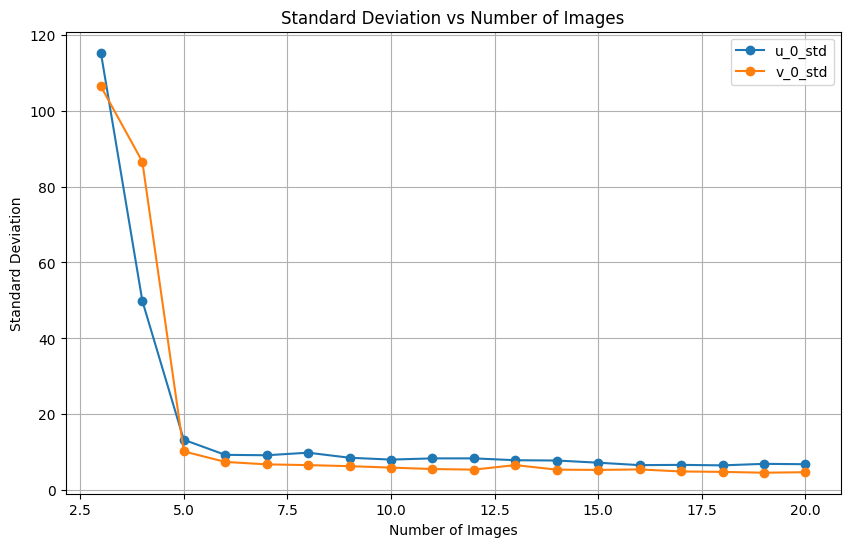

In [7]:
random.seed(0)
max_N_images = 20
N_images = list(range(3, max_N_images + 1))
n_samples = 100

# since V is a stack of two equations per image,
# I can use them to compute K instead of recomputing V each time
index_to_select = list(range(0, len(V), 2))

u0_std = []
v0_std = []

for n_images in range(3, max_N_images + 1):
    current_sample = 1
    principal_point_coord = []
    while current_sample <= n_samples:
        selected_images = np.array(random.sample(index_to_select, n_images))
        _V = np.concatenate([V[selected_images], V[selected_images + 1]])

        # some matrices could be not positive definite -> no solution
        try:
            K = u.get_intrinsic(np.array(_V))
        except:
            continue
        
        principal_point_coord.append([K[0,2], K[1,2]])
        current_sample += 1
    
    principal_point_coord = np.stack(principal_point_coord)
    _u0_std, _v0_std = principal_point_coord.std(axis=0)
    u0_std.append(_u0_std.item())
    v0_std.append(_v0_std.item())
    
plt.figure(figsize=(10, 6))
plt.plot(N_images, u0_std, marker='o', label='u_0_std')
plt.plot(N_images, v0_std, marker='o', label='v_0_std')
plt.xlabel('Number of Images')
plt.ylabel('Standard Deviation')
plt.title('Standard Deviation vs Number of Images')
plt.grid(True)
plt.legend()
plt.show()

## Exercise 5

Optionally, you could compare the estimated $R, t$ with the ones stored in the files `pose_[index].yaml`, respectively in the fields $R_{CS}$ and $T_{CS}$. A possible way to compare two rotation matrices $R_A$ and $R_B$ is computing the Frobenius norm of the difference: $||R_A − R_B||_F$, but this comparison is not particularly meaningful. A better option is:
- Compute the rotation matrix from frame $A$ to frame $B$: $R_{AB} = R_BR_A^T$
- Compute the corresponding angle of rotation: $$ \theta = \arccos\left(\frac{tr(R_{AB}) - 1}{2}\right), $$ where $|\theta|$ is a measure of how the two rotation matrices differ.

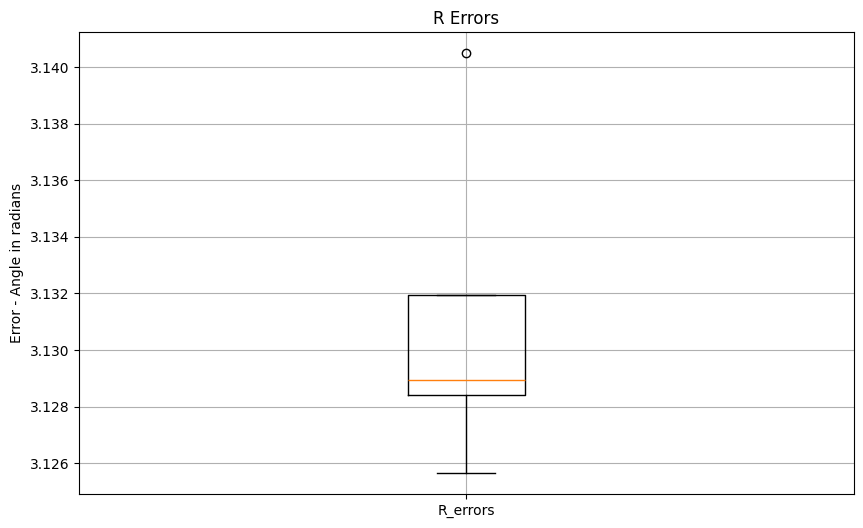

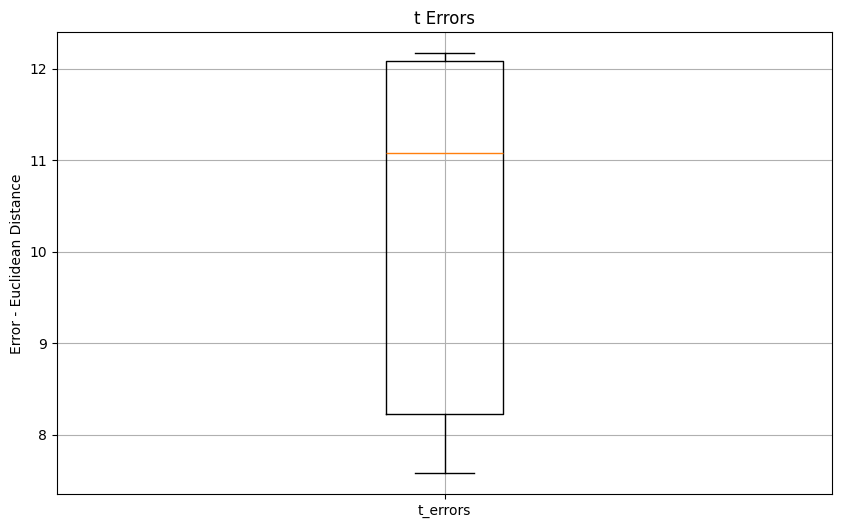

In [8]:
R_errors = []
t_errors = []

for i, pose in enumerate(poses_path[:5]):
    with open(pose, 'r') as file:
        data = yaml.safe_load(file)
        R = all_R[i]
        t = all_t[i]
        R_CS = np.array(data["R_CS"]).reshape(3,3)
        t_CS = np.array(data["T_CS"]) * 1000    # in our code we consider millimiters, in yaml file meters
        
        R_AB = R_CS @ R.T
        R_errors.append(np.absolute(np.arccos((np.trace(R_AB) - 1) / 2)))
        t_errors.append(np.linalg.norm(t - t_CS))
        
# Boxplot for R_errors
plt.figure(figsize=(10, 6))
plt.boxplot(R_errors, tick_labels=['R_errors'])
plt.ylabel('Error - Angle in radians')
plt.title('R Errors')
plt.grid(True)
plt.show()

# Boxplot for t_errors
plt.figure(figsize=(10, 6))
plt.boxplot(t_errors, tick_labels=['t_errors'])
plt.ylabel('Error - Euclidean Distance')
plt.title('t Errors')
plt.grid(True)
plt.show()

## Exercise 6

Optionally, you could print a checkerboard and apply the previous steps to a set of images acquired with your own smartphone, webcam or digital camera (thus, calibrating your device).

## Exercise 7

Optionally, you could minimize the reprojection error (instead of the algebraic one), using the Maximum Likelihood Estimation approach suggested in Section 3.2 of [Zhang, 2002].

In [9]:
# Rodrigues Formula reference:
# https://en.wikipedia.org/wiki/Axis%E2%80%93angle_representation

checkerboard_world_corners = []
for i in range(grid_size[0] * grid_size[1]):
    grid_size_cv2 = tuple(reversed(grid_size)) 
    u_index, v_index = np.unravel_index(i, grid_size_cv2)
        
    # finding the (x,y) coordinates wrt the checkerboard
    x_mm = (u_index) * square_size
    y_mm = (v_index) * square_size
    
    checkerboard_world_corners.append([x_mm, y_mm, 0, 1])

checkerboard_world_corners = np.stack(checkerboard_world_corners)

checkerboard_image_corners = []
for image in images_path:
    corners = u.get_corners(image, grid_size)
    checkerboard_image_corners.append(corners)
    
checkerboard_image_corners = np.concatenate(checkerboard_image_corners).reshape(-1, grid_size[0] * grid_size[1], 2)
    
all_params = [K[0,0], K[0,1], K[0,2], K[1,1], K[1,2]]
all_r = []
for i, R in enumerate(all_R):
    r, theta = u.get_rot_axis_from_R(R)
    all_r += r.tolist()
    
all_params += all_r + list(np.array(all_t).flatten())

# least square computed using Levenberg-Marquardt
least_square_output = least_squares(
    u.compute_residuals,
    all_params,
    args=(checkerboard_world_corners, checkerboard_image_corners),
    method="lm"
)

# reconstructing the solutions
n_images = (len(all_params) - 5) // 3 // 2
alpha_u, skew, u_0, alpha_v, v_0 = least_square_output.x[:5]

refined_K = np.stack([
    [alpha_u, skew, u_0],
    [0, alpha_v, v_0],
    [0, 0, 1]
])

r = np.array(least_square_output.x[5:(5 + (n_images * 3))]).reshape(-1, 3)
refined_t = np.array(least_square_output.x[-(n_images * 3):]).reshape(-1, 3)

refined_R = np.stack([u.get_R_from_axis(r[i]) for i in range(n_images)])

In [10]:
# getting the image and extrinsics
img_path = images_path[1]
R1 = refined_R[1]
t1 = refined_t[1]

# combining R and t
P = u.get_projection_matrix(refined_K, R1, t1)

corners = u.get_corners(img_path, grid_size)
projected_corners = []

error = 0
for index, corner in enumerate(corners):
    u_coord = corner[0]
    v_coord = corner[1]

    grid_size_cv2 = tuple(reversed(grid_size))
    u_index, v_index = np.unravel_index(index, grid_size_cv2)

    # the coordinates of the corner w.r.t. the reference corner at position (0,0) of the corners array
    x_mm = (u_index) * square_size
    y_mm = (v_index) * square_size

    point_m = np.array([x_mm, y_mm, 0, 1])

    projected_u, projected_v = u.project(point_m, P)[0]
    projected_corners.append((projected_u, projected_v))
    
    error += (projected_u - u_coord)**2 + (projected_v - v_coord)**2

print(f"Error: {error:.2f}")
print(f"Mean error per corner: {error/len(corners):.2f}")

# showing the projected corners
image = cv2.imread(img_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # type: ignore

for corner in projected_corners:
    u_coord, v_coord = int(corner[0]), int(corner[1])
    cv2.circle(image_rgb, (u_coord, v_coord), radius=5, color=(255, 0, 0), thickness=-1)

px.imshow(image_rgb)

Error: 10.32
Mean error per corner: 0.12


## Exercise 8

Optionally, you could add radial distortion compensation to the basic Zhang’s calibration procedure (refer to the complementary slides of `Lecture 3, p. 49`)

$$ \begin{cases} \hat{u} = (u - u_0)(1 + k_1r_d^2 + k_2r_d^4) + u_0 \\ \hat{v} = (v - v_0)(1 + k_1r_d^2 + k_2r_d^4) + v_0 \end{cases} \\ \ \\ r_d^2 = \left(\frac{u - u_0}{\alpha_u}\right)^2 + \left(\frac{v - v_0}{\alpha_v}\right)^2 \quad\quad\quad K = \begin{bmatrix} \alpha_u & \alpha_u cot\omega & u_0 \\ 0 & \alpha_v / \sin\omega & v_0 \\ 0 & 0 & 1 \end{bmatrix} $$

Where $u, v$ are the ideal projections (in absence of radial distortion) obtained by applying the projection matrix $P$ to $X_w = [X \ Y \ Z]^T$

In [11]:
all_k = []

for i, path in enumerate(images_path):
    img_path = path
    R_i = all_R[i]
    t_i = all_t[i]
    P = u.get_projection_matrix(K, R_i, t_i)

    k1, k2 = u.get_radial_distortion(img_path, grid_size, square_size, K, P)
    all_k.append([k1, k2])

## Exercise 9

Optionally, you could compute the total reprojection error with radial distortion compensation and make a comparison to the one without compensation.